<a href="https://colab.research.google.com/github/arnoldjames98/arnoldjames98.github.io/blob/main/systemKinematics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Biodegradable Seed Spreading Robot](https://arnoldjames98.github.io/)
# System Kinematics

### 1. Create a figure (either in python, in a vector-based drawing program like inkscape or illustrator, or as a solidworks rendering) of your system kinematics.

TODO: Describe figure and add correct measurements to table

![Mechanism Drawing](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/assignment3/mechanism.png)

| Length | Rigid Body | Measurement (cm)
| --- | --- | --- |
| L10 | Yellow | 3 |
| L02 | Purple | 6.89 |
| L42 | Purple | 9.73 |
| L40 | Purple | 7.37 |
| L31 | Red | 6.6 |
| L61 | Red | 12.36 | 
| L63 | Red | 5.84 |
| L54 | Green | 5.79 |
| L32 | Orange | 3.59 |
| L56 | Blue | 10.04 |
| L5E | Blue | 19.40 |
| LE6 | Blue | 10.04 |


### 2. Make the device in paper or cardboard. You need an up-to-date model if it has changed from your individual assignments. The paper model should dimensionally match your code.

TODO: May need to add a brief description too.
![Mechanism Drawing](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/assignment3/CardboardPaper1.1.jpg)
![Mechanism Drawing](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/assignment3/CardboardPaper2.1.jpg)

### 3. Using a pynamics-based script, develop a kinematic model for your device.

In [1]:
%matplotlib inline
!pip install pynamics

import all required packages

In [2]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
#from pynamics.body import Body
#from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
#from pynamics.particle import Particle
import pynamics.integration
import sympy
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
#from pynamics.constraint import Constraint
import scipy.optimize

Create a pynamics system

In [3]:
system = System()
pynamics.set_system(__name__,system)

Declare all length constants

In [4]:
# TODO: Add correct measurements when defining length constants
# We may also considering our angle constraints for the triangular links here
# Since we have to define constraint equations using different pathways, don't
# delete any of these until the end

# From Loop Closure Eq. #1
l_10 = Constant(3,'l_10',system)
l_31 = Constant(6.6,'l_31',system)
l_32 = Constant(3.59,'l_32',system)
l_02 = Constant(6.89,'l_02',system)

# From Loop Closure Eq. #2
#l_10 already is included in Eq. 1
l_61 = Constant(12.363,'l_61',system)
l_56 = Constant(10.04,'l_56',system)
l_54 = Constant(5.79,'l_54',system)
l_40 = Constant(7.37,'l_54',system)

# From Loop Closure Eq. #3
#l_32 already is included in Eq. 1
#l_54 already is included in Eq. 2
#l_56 already is included in Eq. 2
l_63 = Constant(5.84,'l_63',system)
l_42 = Constant(9.73,'l_42',system)

# End effector
l_E6 = Constant(10.04,'l_E6',system)
l_5E = Constant(19.396,'l_5E',system) # update with correct value

Create the differentiable state variables, cooresponding to the joint angles (we might not need all of these depending on how we do the constraints)

In [5]:
# Note: All angles are measured CCW

# Input state variable (angle of crank on yellow link)
qY,qY_d,qY_dd = Differentiable('qY',system) # Yellow input link, measured from base frame coordinates

# Other state variables (angles of the four undefined links)
# Note that the purple link is ground so is fully defined
qO,qO_d,qO_dd = Differentiable('qO',system) # Orange link w.r.t base frame
qG,qG_d,qG_dd = Differentiable('qG',system) # Green link w.r.t base frame

# Links defined w.r.t non-ground link (not connected to ground)
qR,qR_d,qR_dd = Differentiable('qR',system) # Red link w.r.t yellow link frame
qB,qB_d,qB_dd = Differentiable('qB',system) # Blue link w.r.t green link frame

Initial guess for starting positions

In [6]:
# TODO: We can measure the angles on our directly from our figure to make some guesses
initialvalues = {}
# Yellow link w.r.t base
initialvalues[qY]=130*pi/180
initialvalues[qY_d]=0

# Orange link w.r.t base (measure angle from the standard horizontal x-axis, the shape of the purple ground link is not needed here)
initialvalues[qO]=130*pi/180
initialvalues[qO_d]=0

# Green link w.r.t base (measure angle from the standard horizontal x-axis, the shape of the purple ground link is not needed here)
initialvalues[qG]=160*pi/180
initialvalues[qG_d]=0

# Red link w.r.t yellow link frame
initialvalues[qR]=30*pi/180
initialvalues[qR_d]=0

# Blue link w.r.t green link frame
initialvalues[qB]=60*pi/180
initialvalues[qB_d]=0

Retrieve state variables in the order they are stored in the system

In [7]:
# Not sure if we need this, but it's included in the tutorial
statevariables = system.get_state_variables()

Create the main reference frames, with one cooresponding to each rigid link
**Need to update the figure in this notebook, for now refer to first slide of google slides**

In [8]:
N = Frame('N') # Purple (ground) link

# Defined w.r.t to ground
Y = Frame('Y') # Yellow
O = Frame('O') # Orange
G = Frame('G') # Green

# Defined w.r.t to other links 
# Note that both are directed towards p6
# Important since this is how the angle representing the link is defined
R = Frame('R') # Red w.r.t yellow
B = Frame('B') # Blue w.r.t green

# Helpful additional frames for triangular links
# These frames define the constant angles within the triangular joints
R_to_p3 = Frame('R_to_p3') # Red w.r.t yellow (+ constant degrees to align x-axis with p3)
B_to_pE = Frame('B_to_pE') # Blue w.r.t green (+ constant degrees to align x-axis with pE)
B_plus_180 = Frame('B_plus_180') # Blue with x axis in opposite direction
R_from_p3 = Frame('R_from_p3') # Red rotated so that it can point from p3 to p6 (CW rotation)
B_from_p6 = Frame('B_from_p6') # Blue rotated so it can go from p6 to pE

Declare N as the Newtonian (fixed) frame

In [9]:
system.set_newtonian(N)

Rotate frames about their z-axes so they align with the correct rigid link.

In [10]:
# Frames cooresponding to joint angles
Y.rotate_fixed_axis_directed(N,[0,0,1],qY,system) # Yellow
O.rotate_fixed_axis_directed(N,[0,0,1],qO,system) # Orange
G.rotate_fixed_axis_directed(N,[0,0,1],qG,system) # Green
R.rotate_fixed_axis_directed(Y,[0,0,1],qR,system) # Red w.r.t yellow
B.rotate_fixed_axis_directed(G,[0,0,1],qB,system) # Blue w.r.t green

# Helpful frames for triangular joints
# 6.007 degrees from B frame to align axis with p3
R_to_p3.rotate_fixed_axis_directed(Y,[0,0,1],qR+6.007*pi/180,system) # Red w.r.t yellow
# 15 degrees from B frame to align axis with pE
B_to_pE.rotate_fixed_axis_directed(G,[0,0,1],qB+15*pi/180,system) # Blue w.r.t green
# B plus 180 (this comes in handy later when defining a vector in the opposite direction)
B_plus_180.rotate_fixed_axis_directed(G,[0,0,1],qB+180*pi/180,system) # Blue reversed
# R - 5.84 degrees (CW rotation) from p3 to p6
R_from_p3.rotate_fixed_axis_directed(Y,[0,0,1],qR-12.8*pi/180,system) # Red w.r.t yellow
# Rotate B frame 30 degrees CCW to go from p6 to pE
B_from_p6.rotate_fixed_axis_directed(G,[0,0,1],qB+30*pi/180,system)

Define vectors for each of the joint locations (not necessarily the vectors connecting two vectors)

In [11]:
# Vectors representing the joint locations w.r.t N frame
# Fixed points on pruple (ground) link
p0 = 0*N.x # P0 is at the origin (shifted by -10, -10 units from figure we are basing our units off of)
p2 = -6.6*N.x - 1.97*N.y # Coordinates given
p4 = -2.6*N.x + 9.9*N.y # Coordinates given

# Note that for all other points, they are still w.r.t N frame, but they can be defined from different directions/pathways
# Defining the same point from different directions/pathways is needed for constraints
# Points directly connected to ground
p1_from_p0 = p0 + l_10*Y.x
p3_from_p2 = p2 + l_32*O.x
p5_from_p4 = p4 + l_54*G.x

# Additional points (Consider alternative defnitions of these)
p6_from_p1 = p1_from_p0 + l_61*R.x
pE_from_p5 = p5_from_p4 + l_5E*B_to_pE.x # 15 degrees CCW from B frame x axis

# Alternate pathways to points (used to make LHS and RHS of loop equations defined differently)
p3_from_p1 = p1_from_p0 + l_31*R_to_p3.x # 6.007 degrees (CCW) from R frame x axis
p5_from_p6 = p6_from_p1 + l_56*B_plus_180.x # 180 degress (CCW) from B frame x axis
p6_from_p3 = p3_from_p2 + l_63*R_from_p3.x # -5.84 degress (CW) from R frame x axis
pE_from_p6 = p6_from_p3 + l_E6*B_from_p6.x

# List of points to that will be used for plotting 
# Doesn't matter which version of points like p1 we use since they will be constrained to be equal
points = [p0, p1_from_p0, p2, p3_from_p2, p4, p5_from_p4, p6_from_p1, pE_from_p6]

Define vectors that connect the joint locations

In [12]:
## When subtracting: # Vector to head minus vector to tail

## From Loop Closure Eq. #1
#r_10 = p1_from_p0
#r_31 = p3_from_p1 - p1_from_p0
#r_32 = p3_from_p2 - p2 
#r_02 = -p2

## From Loop Closure Eq. #2
##r_10 already is included in Eq. 1
#r_61 = p6 - p1
#r_56 = p5_alt - p6
#r_54 = p5 - p4
#r_40 = p4

## From Loop Closure Eq. #3
##r_32 already is included in Eq. 1
##r_54 already is included in Eq. 2
##r_56 already is included in Eq. 2
#r_63 = p6 - p3
#r_42 = p4 - p2

## End effector
#r_E6 = pE - p6
#r_E5 = pE - p5

Create a list of initial values ini0 in the order of the system’s state variables

In [13]:
statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

Create all the vector equation constraints (e.g., loop closure equations, rigid link constraints, etc.)

![Loop Closure Equations](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/assignment3/loopClosureEqs.png)

In [14]:
# Loop closure equations (constraint to ensure all loops are equal to zero)
# Equation 1 (R02 + R10 + R31 = R32)
loopClosure1 = p3_from_p1 - p3_from_p2
#print("p3_from_p2:", p3_from_p2)
#print("p3_from_p1:", p3_from_p1)
#print("loopClosure1", loopClosure1)

# Equation 2 (R10 + R61 + R56 = R40 + R54)
loopClosure2 = p5_from_p4 - p5_from_p6
#print("p5_from_p4:", p5_from_p4)
#print("p5_from_p6:", p5_from_p6)
#print("loopClosure2", loopClosure2)

# Equation 3 (R42 + R54 = R32 + R63 + R56)
# This one is a bit confusing since really p6 is being defined by two pathways,
# but because of the direction of R56 it is done this way
loopClosure3 = p6_from_p3 - p5_from_p4 - p5_from_p6

# TODO: Are there any other contraint equations? Seems like we need 4 since we have 4 unknowns
# I'm less sure about this one
blueLink = pE_from_p5 - pE_from_p6

Convert the vector constraints into scalar equations that can be solved

In [15]:
eq = []

# Loop closure equations
eq.append((loopClosure1).dot(N.x))
eq.append((loopClosure1).dot(N.y))

eq.append((loopClosure2).dot(N.x))
eq.append((loopClosure2).dot(N.y))

eq.append((loopClosure3).dot(N.x))
eq.append((loopClosure3).dot(N.y))

eq.append((blueLink).dot(N.x))
eq.append((blueLink).dot(N.y))

# Show the equations
print(eq)

# Take the derivatives
eq_d=[(system.derivative(item)) for item in eq]

# Show the derivatives
print(eq_d)

[l_10*cos(qY) - l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299) - l_32*cos(qO) + 6.6, l_10*sin(qY) + l_31*sin(qY)*cos(qR + 0.104841928167299) + l_31*sin(qR + 0.104841928167299)*cos(qY) - l_32*sin(qO) + 1.97, -l_10*cos(qY) + l_54*cos(qG) + l_56*sin(qG)*sin(qB + 3.14159265358979) - l_56*cos(qG)*cos(qB + 3.14159265358979) + l_61*sin(qR)*sin(qY) - l_61*cos(qR)*cos(qY) - 2.6, -l_10*sin(qY) + l_54*sin(qG) - l_56*sin(qG)*cos(qB + 3.14159265358979) - l_56*sin(qB + 3.14159265358979)*cos(qG) - l_61*sin(qR)*cos(qY) - l_61*sin(qY)*cos(qR) + 9.9, -l_10*cos(qY) + l_32*cos(qO) - l_54*cos(qG) + l_56*sin(qG)*sin(qB + 3.14159265358979) - l_56*cos(qG)*cos(qB + 3.14159265358979) + l_61*sin(qR)*sin(qY) - l_61*cos(qR)*cos(qY) - l_63*sin(qY)*sin(qR - 0.223402144255274) + l_63*cos(qY)*cos(qR - 0.223402144255274) - 4.0, -l_10*sin(qY) + l_32*sin(qO) - l_54*sin(qG) - l_56*sin(qG)*cos(qB + 3.14159265358979) - l_56*sin(qB + 3.14159265358979)*cos(qG) - l_61*sin(qR)*cos(qY) - l_61

identify independent and dependent variables

In [16]:
qi = [qY] # Yellow link is the input
qd = [qO, qG, qR, qB] # All other links are dependent on the input

for dependent variables, create an initial guess

Create a copy of symbolic constants dictionary and add the initial value of qi to it

In [17]:
constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

substitute constants in equation

In [18]:
eq = [item.subs(constants) for item in eq]
print(eq)

[-5.05589332458525*sin(qR + 0.104841928167299) - 3.59*cos(qO) - 4.24239822393116*cos(qR + 0.104841928167299) + 4.67163717094038, -3.59*sin(qO) - 4.24239822393116*sin(qR + 0.104841928167299) + 5.05589332458525*cos(qR + 0.104841928167299) + 4.26813332935693, 10.04*sin(qG)*sin(qB + 3.14159265358979) + 9.47060745027992*sin(qR) - 10.04*cos(qG)*cos(qB + 3.14159265358979) + 7.37*cos(qG) + 7.94678321855469*cos(qR) - 0.671637170940382, -10.04*sin(qG)*cos(qB + 3.14159265358979) + 7.37*sin(qG) + 7.94678321855469*sin(qR) - 10.04*sin(qB + 3.14159265358979)*cos(qG) - 9.47060745027992*cos(qR) + 7.60186667064307, 10.04*sin(qG)*sin(qB + 3.14159265358979) + 9.47060745027992*sin(qR) - 4.47369954781483*sin(qR - 0.223402144255274) - 10.04*cos(qG)*cos(qB + 3.14159265358979) - 7.37*cos(qG) + 3.59*cos(qO) + 7.94678321855469*cos(qR) - 3.75387964056939*cos(qR - 0.223402144255274) - 2.07163717094038, -10.04*sin(qG)*cos(qB + 3.14159265358979) - 7.37*sin(qG) + 3.59*sin(qO) + 7.94678321855469*sin(qR) - 10.04*sin(qB

convert to numpy array

sum the error

In [19]:
error = (numpy.array(eq)**2).sum()


Convert to a function that scipy can use. Sympy has a “labmdify” function that evaluates an expression, but scipy needs a slightly different format.

In [20]:
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

Take the derivative of the equations to linearize with regard to the velocity variables

Result:       fun: 22.607665513530613
 hess_inv: array([[ 0.0128418 , -0.00339783,  0.00011474,  0.00374299],
       [-0.00339783,  0.00356566, -0.00053311, -0.00415696],
       [ 0.00011474, -0.00053311,  0.00883714,  0.00951164],
       [ 0.00374299, -0.00415696,  0.00951164,  0.01602539]])
      jac: array([-1.43051147e-06, -3.57627869e-06,  1.90734863e-06, -1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 96
      nit: 12
     njev: 16
   status: 0
  success: True
        x: array([ 1.66728667,  4.42955312,  0.68420221, -1.55421275])


2021-02-18 08:50:27,119 - pynamics.output - INFO - calculating outputs
2021-02-18 08:50:27,123 - pynamics.output - INFO - done calculating outputs


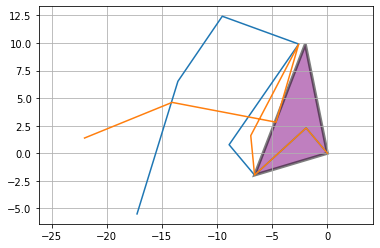

In [21]:
guess = [initialvalues[item] for item in qd]

result = scipy.optimize.minimize(function,guess)
#if result.fun>1e-3:
#    raise(Exception("out of tolerance"))
print("Result:", result)

ini = []

for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]))
points.plot_time()

plt.fill([-2, -6.6, 0], [9.9, -1.97, 0], facecolor='purple', edgecolor="black",linewidth=3, alpha=0.5)

plt.grid()
plt.show()

Make the above plot for readable by manually plotting the points

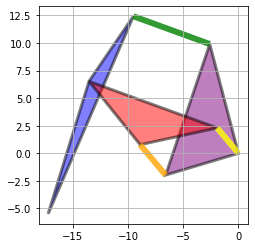

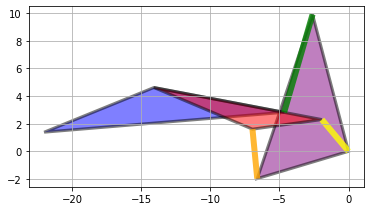

In [22]:
result.fun
#print(points.y)

plt.figure
# Blue link
plt.fill([points.y[0][7,0], points.y[0][6,0], points.y[0][5,0]], [points.y[0][7,1], points.y[0][6,1], points.y[0][5,1]], facecolor='blue', edgecolor="black",linewidth=3, alpha=0.5)
# Purple link
plt.fill([points.y[0][0,0], points.y[0][2,0], points.y[0][4,0]], [points.y[0][0,1], points.y[0][2,1], points.y[0][4,1]], facecolor='purple', edgecolor="black",linewidth=3, alpha=0.5)
# Red link
plt.fill([points.y[0][1,0], points.y[0][3,0], points.y[0][6,0]], [points.y[0][1,1], points.y[0][3,1], points.y[0][6,1]], facecolor='red', edgecolor="black",linewidth=3, alpha=0.5)
# Orange link
plt.fill([points.y[0][2,0], points.y[0][3,0]], [points.y[0][2,1], points.y[0][3,1]], edgecolor="orange",linewidth=6, alpha=0.8)
# Green link
plt.fill([points.y[0][4,0], points.y[0][5,0]], [points.y[0][4,1], points.y[0][5,1]], edgecolor="green",linewidth=6, alpha=0.8)
# Yello link
plt.fill([points.y[0][0,0], points.y[0][1,0]], [points.y[0][0,1], points.y[0][1,1]], edgecolor="yellow",linewidth=6, alpha=0.8)
plt.grid()
plt.axis('scaled')
plt.show()



plt.figure
# Blue link
plt.fill([points.y[1][7,0], points.y[1][6,0], points.y[1][5,0]], [points.y[1][7,1], points.y[1][6,1], points.y[1][5,1]], facecolor='blue', edgecolor="black",linewidth=3, alpha=0.5)
# Purple link
plt.fill([points.y[1][0,0], points.y[1][2,0], points.y[1][4,0]], [points.y[1][0,1], points.y[1][2,1], points.y[1][4,1]], facecolor='purple', edgecolor="black",linewidth=3, alpha=0.5)
# Red link
plt.fill([points.y[1][1,0], points.y[1][3,0], points.y[1][6,0]], [points.y[1][1,1], points.y[1][3,1], points.y[1][6,1]], facecolor='red', edgecolor="black",linewidth=3, alpha=0.5)
# Orange link
plt.fill([points.y[1][2,0], points.y[1][3,0]], [points.y[1][2,1], points.y[1][3,1]], edgecolor="orange",linewidth=6, alpha=0.8)
# Green link
plt.fill([points.y[1][4,0], points.y[1][5,0]], [points.y[1][4,1], points.y[1][5,1]], edgecolor="green",linewidth=6, alpha=0.8)
# Yello link
plt.fill([points.y[1][0,0], points.y[1][1,0]], [points.y[1][0,1], points.y[1][1,1]], edgecolor="yellow",linewidth=6, alpha=0.8)
plt.grid()
plt.axis('scaled')
plt.show()